In [30]:
# Imports
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
#from sklearn.preprocessing import StandardScaler, MinMaxScaler

Preprocessing:

In [2]:
data_1hour = pd.read_csv(Path("../Data/electricitybalancenonv_2_1_2022.csv"), sep=',', decimal='.', encoding='utf-8', index_col='HourUTC', parse_dates=True)

# Splits the data into the two price areas DK1 and DK2
data_dk1 = data_1hour[data_1hour['PriceArea'] == 'DK1']
data_dk1 = data_dk1.asfreq('1H')

data_dk2 = data_1hour[data_1hour['PriceArea'] == 'DK2']
data_dk2 = data_dk2.asfreq('1H')

# Imputes missing values with average of the same hour from previous and following 3 days
def fillnaTotalLoad(data):
    for i in range(len(data)):
        if pd.isna(data.TotalLoad[data.index[i]]):
            other_observations = 0
            for t in range(7):
                if t!= 3:
                    other_observations += data.TotalLoad[data.index[i] - pd.Timedelta(t-3, 'd')]
            data.loc[data.index[i],"TotalLoad"] = round(other_observations/6, 2)
    return data

def changeOutliers(data, columns):
    for i in range(len(data)):
        if data.TotalLoad[data.index[i]] > 10000:
            for column in columns:
                    other_observations = 0
                    for t in range(7):
                        if t!= 3:
                            other_observations += data[column][data.index[i] - pd.Timedelta(t-3, 'd')]
                    data.loc[data.index[i],column] = round(other_observations/6, 2)
    return data

In [6]:
data_dk1 = fillnaTotalLoad(data_dk1)
data_dk1

,HourDK,PriceArea,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,2020-01-01T01:00:00,DK1,1892.60,204.30,220.77,355.35,10.70,2.0,2.97,0.00,108.07,1070.10,657.25,-1263.0,282.0,990.0
2020-01-01 01:00:00+00:00,2020-01-01T02:00:00,DK1,1830.97,163.25,220.24,336.92,10.74,2.0,2.91,0.00,106.29,1273.98,749.12,-1339.0,326.0,731.0
2020-01-01 02:00:00+00:00,2020-01-01T03:00:00,DK1,1782.09,157.09,219.65,329.49,10.76,2.0,2.77,0.00,107.20,1568.97,829.06,-1393.0,394.0,295.0
2020-01-01 03:00:00+00:00,2020-01-01T04:00:00,DK1,1745.69,163.37,220.16,321.75,10.73,2.0,2.76,0.00,106.83,1732.34,898.73,-1118.0,158.0,-41.0
2020-01-01 04:00:00+00:00,2020-01-01T05:00:00,DK1,1781.79,172.77,222.83,369.13,10.87,2.0,2.78,0.00,117.44,1852.97,887.99,-1141.0,-71.0,-485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,2021-12-31T20:00:00,DK1,2301.86,206.49,154.31,224.50,11.32,1.0,2.20,0.73,99.80,859.29,795.78,-177.0,597.0,-225.0
2021-12-31 20:00:00+00:00,2021-12-31T21:00:00,DK1,2211.26,153.95,146.71,187.90,10.90,1.0,2.14,0.73,99.02,693.77,791.86,50.0,597.0,-268.0
2021-12-31 21:00:00+00:00,2021-12-31T22:00:00,DK1,2154.02,228.84,154.46,171.63,10.86,1.0,2.10,0.72,99.39,624.31,992.84,-361.0,593.0,-154.0


In [5]:
data_dk1 = changeOutliers(data_dk1, columns=['TotalLoad', 'Biomass', 'FossilGas', 'FossilHardCoal', 'FossilOil', 'OtherRenewable', 'Waste'])
data_dk1

,HourDK,PriceArea,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,2020-01-01T01:00:00,DK1,1892.60,204.30,220.77,355.35,10.70,2.0,2.97,0.00,108.07,1070.10,657.25,-1263.0,282.0,990.0
2020-01-01 01:00:00+00:00,2020-01-01T02:00:00,DK1,1830.97,163.25,220.24,336.92,10.74,2.0,2.91,0.00,106.29,1273.98,749.12,-1339.0,326.0,731.0
2020-01-01 02:00:00+00:00,2020-01-01T03:00:00,DK1,1782.09,157.09,219.65,329.49,10.76,2.0,2.77,0.00,107.20,1568.97,829.06,-1393.0,394.0,295.0
2020-01-01 03:00:00+00:00,2020-01-01T04:00:00,DK1,1745.69,163.37,220.16,321.75,10.73,2.0,2.76,0.00,106.83,1732.34,898.73,-1118.0,158.0,-41.0
2020-01-01 04:00:00+00:00,2020-01-01T05:00:00,DK1,1781.79,172.77,222.83,369.13,10.87,2.0,2.78,0.00,117.44,1852.97,887.99,-1141.0,-71.0,-485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,2021-12-31T20:00:00,DK1,2301.86,206.49,154.31,224.50,11.32,1.0,2.20,0.73,99.80,859.29,795.78,-177.0,597.0,-225.0
2021-12-31 20:00:00+00:00,2021-12-31T21:00:00,DK1,2211.26,153.95,146.71,187.90,10.90,1.0,2.14,0.73,99.02,693.77,791.86,50.0,597.0,-268.0
2021-12-31 21:00:00+00:00,2021-12-31T22:00:00,DK1,2154.02,228.84,154.46,171.63,10.86,1.0,2.10,0.72,99.39,624.31,992.84,-361.0,593.0,-154.0


In [25]:
data_dk1['2020-02-27 10:00:00+00:00':'2020-02-27 18:00:00+00:00']


,HourDK,PriceArea,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,,,
2020-02-27 10:00:00+00:00,2020-02-27T11:00:00,DK1,3192.48,307.51,443.84,975.95,13.54,3.51,4.12,209.64,128.34,184.07,118.32,132.0,-290.0,904.0
2020-02-27 11:00:00+00:00,2020-02-27T12:00:00,DK1,3043.91,309.79,532.91,1053.04,15.59,3.51,4.30,270.96,142.82,235.70,80.56,-451.0,-566.0,1364.0
2020-02-27 12:00:00+00:00,2020-02-27T13:00:00,DK1,3092.25,308.03,502.55,978.91,14.35,3.50,4.59,254.80,140.95,250.95,66.47,140.0,-582.0,956.0
2020-02-27 13:00:00+00:00,2020-02-27T14:00:00,DK1,2796.38,219.03,269.79,561.46,11.08,3.50,3.67,194.99,86.10,204.72,99.62,332.0,-538.0,939.0
2020-02-27 14:00:00+00:00,2020-02-27T15:00:00,DK1,2921.25,310.62,523.41,757.31,14.87,3.50,4.56,129.31,133.00,164.36,126.22,-8.0,-286.0,1049.0
2020-02-27 15:00:00+00:00,2020-02-27T16:00:00,DK1,2925.02,313.38,553.78,855.72,14.73,3.50,4.57,52.96,132.76,155.58,407.27,-246.0,-303.0,975.0
2020-02-27 16:00:00+00:00,2020-02-27T17:00:00,DK1,3045.90,313.80,604.01,942.66,14.84,3.50,4.34,7.89,145.15,139.44,454.20,150.0,-405.0,668.0
2020-02-27 17:00:00+00:00,2020-02-27T18:00:00,DK1,3184.40,312.43,566.63,980.33,15.07,3.50,4.25,0.07,135.69,198.28,593.80,-360.0,-359.0,1086.0
2020-02-27 18:00:00+00:00,2020-02-27T19:00:00,DK1,3033.17,312.62,554.57,940.28,15.06,3.49,4.46,0.00,134.89,303.86,538.17,-754.0,-313.0,1283.0


<AxesSubplot:xlabel='HourUTC'>

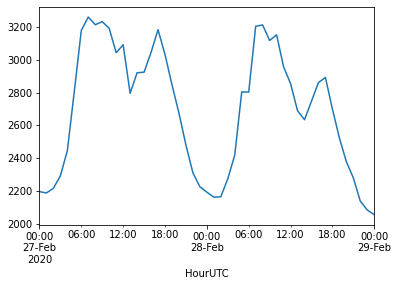

In [51]:
data_dk1['2020-02-27 00:00:00+00:00':'2020-02-29 00:00:00+00:00']['TotalLoad'].plot()


HourUTC
2020-01-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-02-29 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-03-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-04-30 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-05-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-30 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-07-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-08-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-09-30 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-10-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-11-30 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2020-12-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2021-01-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2021-02-28 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2021-03-31 00:00:00+00:00    AxesSubplot(0.125,0.125;0.775x0.755)
20

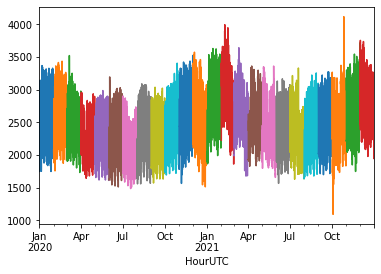

In [50]:
data_dk1['TotalLoad'].resample('M').plot()

In [51]:
data_dk2 = fillnaTotalLoad(data_dk2)
data_dk2

,HourDK,PriceArea,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,2020-01-01T01:00:00,DK2,1337.38,460.20,40.63,187.02,3.86,NaN,NaN,0.0,72.81,219.04,105.03,-585.0,-282.0,1154.0
2020-01-01 01:00:00+00:00,2020-01-01T02:00:00,DK2,1293.37,412.73,34.47,183.55,3.94,NaN,NaN,0.0,71.78,225.98,96.27,-580.0,-326.0,1207.0
2020-01-01 02:00:00+00:00,2020-01-01T03:00:00,DK2,1241.41,411.35,32.06,179.70,3.85,NaN,NaN,0.0,72.69,238.89,114.01,-377.0,-394.0,996.0
2020-01-01 03:00:00+00:00,2020-01-01T04:00:00,DK2,1197.14,457.83,31.95,183.99,8.36,NaN,NaN,0.0,69.84,254.02,136.80,-469.0,-158.0,723.0
2020-01-01 04:00:00+00:00,2020-01-01T05:00:00,DK2,1183.64,409.18,31.87,185.57,11.86,NaN,NaN,0.0,64.49,301.81,144.38,-500.0,71.0,507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,2021-12-31T20:00:00,DK2,1634.98,403.69,84.02,162.20,34.69,NaN,NaN,0.0,75.65,251.80,748.46,883.0,-597.0,-376.0
2021-12-31 20:00:00+00:00,2021-12-31T21:00:00,DK2,1548.81,310.04,84.23,154.86,34.74,NaN,NaN,0.0,75.67,271.44,643.69,992.0,-597.0,-386.0
2021-12-31 21:00:00+00:00,2021-12-31T22:00:00,DK2,1489.56,373.17,85.97,157.21,34.72,NaN,NaN,0.0,75.99,250.85,696.84,964.0,-593.0,-523.0


In [52]:
data_dk2[data_dk2.TotalLoad.isna()]

,HourDK,PriceArea,TotalLoad,Biomass,FossilGas,FossilHardCoal,FossilOil,HydroPower,OtherRenewable,SolarPower,Waste,OnshoreWindPower,OffshoreWindPower,ExchangeContinent,ExchangeGreatBelt,ExchangeNordicCountries
HourUTC,,,,,,,,,,,,,,,,


In [53]:
X, y = data_dk1.drop(columns=['TotalLoad']), data_dk1.TotalLoad
X.shape, y.shape

((17544, 15), (17544,))